In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
import wfdb
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

In [55]:
data_path = 'mitbih-af/'

In [56]:
# Get the list of all record files in the folder
# List of Patients
data = ['04015','04043','04048','04126','04746','04908','04936','05091',
           '05121','05261','06426','06453','06995','07162','07859','07879',
           '07910','08215','08219','08378','08405','08434','08455']

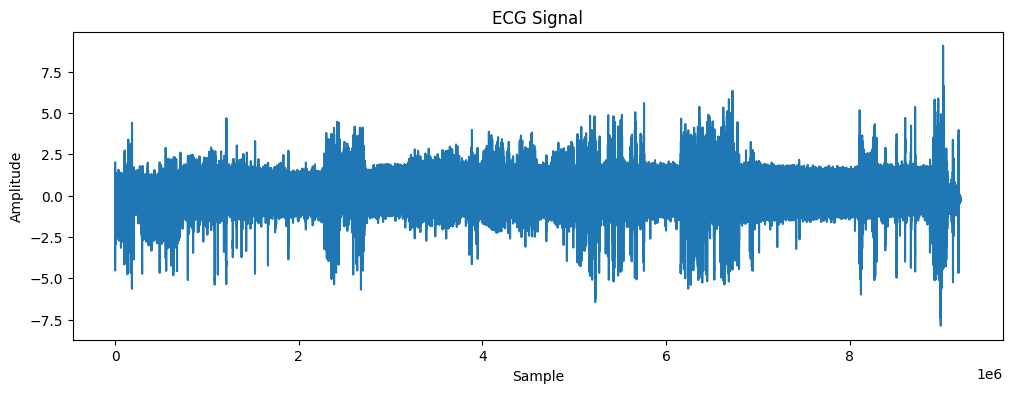

In [57]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [58]:
import numpy as np

# Menghitung kekuatan sinyal (Signal Power)
signal_power = np.var(sig)  # sig adalah sinyal asli

# Menghitung kekuatan noise (Noise Power)
# Untuk data EKG, noise seringkali dianggap sebagai seluruh sinyal karena noise dalam data EKG bervariasi
# Anda dapat menggunakan seluruh sinyal sebagai noise
noise_power = np.var(sig)

# Menghitung SNR
snr = 10 * np.log10(signal_power / noise_power)

print("SNR:", snr)


SNR: 0.0


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [60]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [61]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [62]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

Train:  [      1       2       3 ... 2301436 2301437 2301438] Test:  [      0       7       9 ... 2301431 2301435 2301439]
Epoch 1/100
3596/3596 [==============================] - 19s 4ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 2.3321e-05 - val_root_mean_squared_error: 0.0048
Epoch 2/100
3596/3596 [==============================] - 12s 3ms/step - loss: 8.3567e-06 - root_mean_squared_error: 0.0029 - val_loss: 8.2400e-07 - val_root_mean_squared_error: 9.0775e-04
Epoch 3/100
3596/3596 [==============================] - 12s 3ms/step - loss: 3.2594e-06 - root_mean_squared_error: 0.0018 - val_loss: 1.9586e-06 - val_root_mean_squared_error: 0.0014
Epoch 4/100
3596/3596 [==============================] - 12s 3ms/step - loss: 7.1291e-06 - root_mean_squared_error: 0.0027 - val_loss: 1.9656e-06 - val_root_mean_squared_error: 0.0014
Epoch 5/100
3596/3596 [==============================] - 12s 3ms/step - loss: 2.2625e-06 - root_mean_squared_error: 0.0015 - val_loss: 3.4218

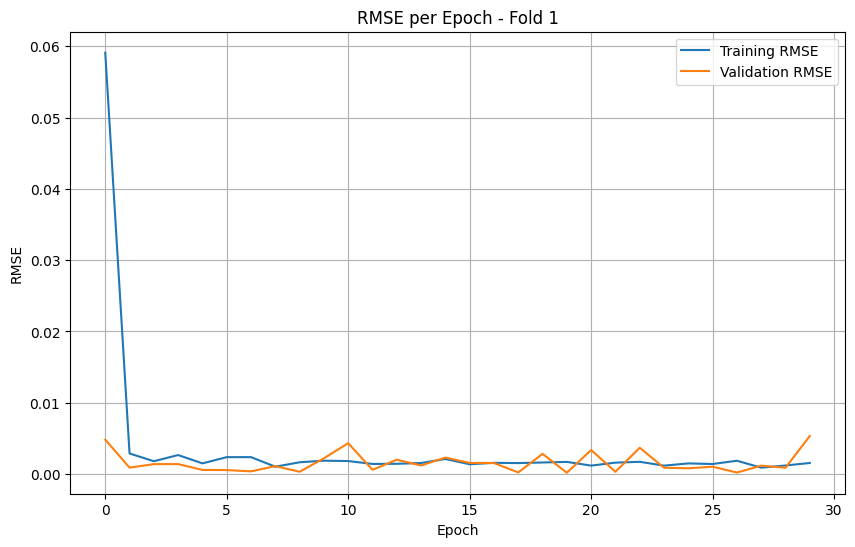

14384/14384 [==============================] - 42s 3ms/step
Signal to Noise Ratio (SNR) fold-1: 61.74210759386624
Root Mean Squared Error (RMSE) fold-1: 0.00019276447508540575
14384/14384 [==============================] - 40s 3ms/step
Train:  [      0       1       3 ... 2301437 2301438 2301439] Test:  [      2       6       8 ... 2301416 2301418 2301432]
Epoch 1/100
3596/3596 [==============================] - 39s 8ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 1.6685e-06 - val_root_mean_squared_error: 0.0013
Epoch 2/100
3596/3596 [==============================] - 28s 8ms/step - loss: 3.2523e-06 - root_mean_squared_error: 0.0018 - val_loss: 6.6385e-06 - val_root_mean_squared_error: 0.0026
Epoch 3/100
3596/3596 [==============================] - 28s 8ms/step - loss: 6.4917e-06 - root_mean_squared_error: 0.0025 - val_loss: 2.9575e-07 - val_root_mean_squared_error: 5.4383e-04
Epoch 4/100
3596/3596 [==============================] - 28s 8ms/step - loss: 2.3129e-06 

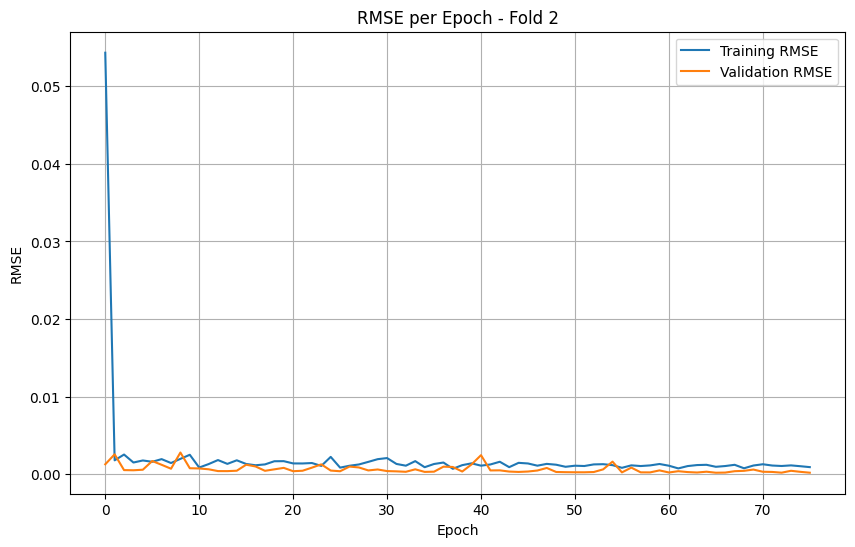

14384/14384 [==============================] - 41s 3ms/step
Signal to Noise Ratio (SNR) fold-2: 61.04413351970359
Root Mean Squared Error (RMSE) fold-2: 0.00020597485970933542
14384/14384 [==============================] - 39s 3ms/step
Train:  [      0       2       5 ... 2301437 2301438 2301439] Test:  [      1       3       4 ... 2301427 2301430 2301434]
Epoch 1/100
3596/3596 [==============================] - 40s 8ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 1.0063e-05 - val_root_mean_squared_error: 0.0032
Epoch 2/100
3596/3596 [==============================] - 29s 8ms/step - loss: 1.8050e-05 - root_mean_squared_error: 0.0042 - val_loss: 4.1418e-06 - val_root_mean_squared_error: 0.0020
Epoch 3/100
3596/3596 [==============================] - 29s 8ms/step - loss: 1.4973e-05 - root_mean_squared_error: 0.0039 - val_loss: 1.0959e-05 - val_root_mean_squared_error: 0.0033
Epoch 4/100
3596/3596 [==============================] - 30s 8ms/step - loss: 5.1688e-06 - ro

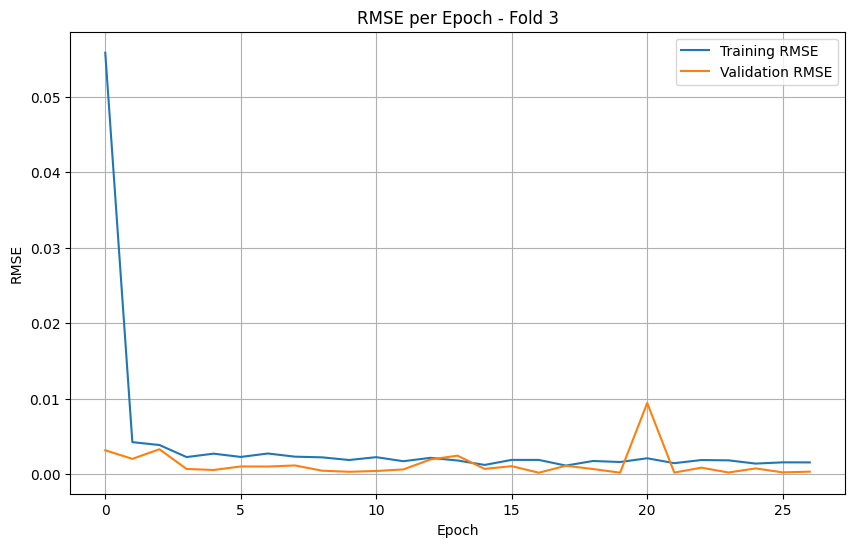

14384/14384 [==============================] - 42s 3ms/step
Signal to Noise Ratio (SNR) fold-3: 61.480736549553896
Root Mean Squared Error (RMSE) fold-3: 0.0001973795363460646
14384/14384 [==============================] - 39s 3ms/step
Train:  [      0       1       2 ... 2301434 2301435 2301439] Test:  [      5      20      24 ... 2301436 2301437 2301438]
Epoch 1/100
3596/3596 [==============================] - 39s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 8.0088e-06 - val_root_mean_squared_error: 0.0028
Epoch 2/100
3596/3596 [==============================] - 27s 8ms/step - loss: 4.0621e-06 - root_mean_squared_error: 0.0020 - val_loss: 8.5905e-06 - val_root_mean_squared_error: 0.0029
Epoch 3/100
3596/3596 [==============================] - 28s 8ms/step - loss: 8.2840e-06 - root_mean_squared_error: 0.0029 - val_loss: 5.1632e-06 - val_root_mean_squared_error: 0.0023
Epoch 4/100
3596/3596 [==============================] - 27s 8ms/step - loss: 4.5116e-06 - ro

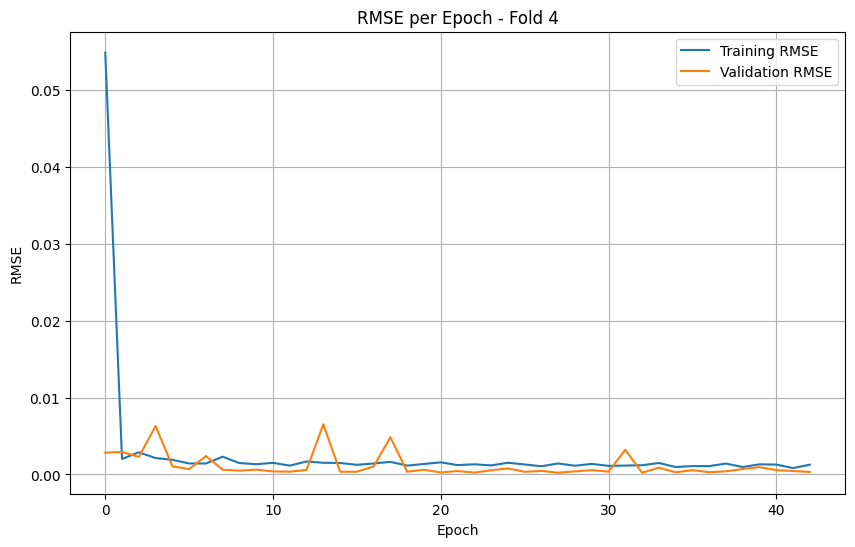

14384/14384 [==============================] - 60s 4ms/step
Signal to Noise Ratio (SNR) fold-4: 60.57566172515703
Root Mean Squared Error (RMSE) fold-4: 0.0002203429576317574
14384/14384 [==============================] - 38s 3ms/step
Train:  [      0       1       2 ... 2301437 2301438 2301439] Test:  [     13      17      22 ... 2301421 2301423 2301426]
Epoch 1/100
3596/3596 [==============================] - 46s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 2.4052e-06 - val_root_mean_squared_error: 0.0016
Epoch 2/100
3596/3596 [==============================] - 36s 10ms/step - loss: 3.7575e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.3414e-07 - val_root_mean_squared_error: 6.5889e-04
Epoch 3/100
3596/3596 [==============================] - 36s 10ms/step - loss: 3.7444e-06 - root_mean_squared_error: 0.0019 - val_loss: 7.3465e-06 - val_root_mean_squared_error: 0.0027
Epoch 4/100
3596/3596 [==============================] - 36s 10ms/step - loss: 6.1320e-

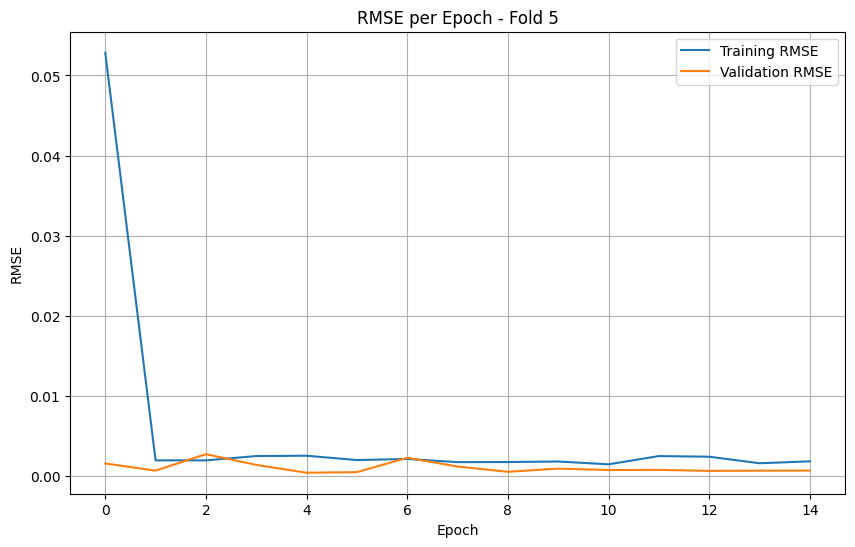

14384/14384 [==============================] - 33s 2ms/step
Signal to Noise Ratio (SNR) fold-5: 55.53963125213967
Root Mean Squared Error (RMSE) fold-5: 0.0003945690336766023
14384/14384 [==============================] - 32s 2ms/step


In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Inisialisasi KFold
kfold = KFold(n_splits=5, shuffle=True)

result_snr = []
result_rmse = []
result_val_snr = []  # Menyimpan SNR validasi untuk setiap fold
result_val_rmse = []  # Menyimpan RMSE validasi untuk setiap fold
list_denoised_data = []
i = 1

# Menginisialisasi hyperparameters
window_size = 1
epochs = 100
batch_size = 128

for train_index, test_index in kfold.split(sign):
    # Print index data train dan test
    print("Train: ", train_index, "Test: ", test_index)

    # Mendapatkan data train dan test
    train_data, test_data = sign[train_index], sign[test_index]

    # Reshape data train dan test
    train_data = np.reshape(train_data, (train_data.shape[0], window_size, 1))
    test_data = np.reshape(test_data, (test_data.shape[0], window_size, 1))

    # Membangun model
    model = Sequential()

    # Encoder
    model.add(LSTM(16, activation='relu', input_shape=(window_size, 1), return_sequences=True))
    model.add(LSTM(8, activation='relu', return_sequences=False))

    # Decoder
    model.add(RepeatVector(window_size))
    model.add(LSTM(8, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer='adam', loss='mse')
    
    # Menambahkan Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Menambahkan loss function dan metrics ke model
    model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

    # Melatih model
    history = model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(test_data, test_data), callbacks=[early_stopping])

    # Plot RMSE tiap epoch
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'RMSE per Epoch - Fold {i}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Menggunakan model untuk denoising data
    denoised_data = model.predict(test_data)

    # Menghitung sinyal asli
    asli = np.max(test_data, axis=1)

    # Menghitung sinyal noise
    noise = asli - np.max(denoised_data, axis=1)

    # Menghitung SNR
    snr = 10 * np.log10(np.sum(asli ** 2) / np.sum(noise ** 2))

    # Menghitung RMSE
    rmse = np.sqrt(mean_squared_error(asli, np.max(denoised_data, axis=1)))

    # Menampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)

    result_snr.append(snr)
    result_rmse.append(rmse)
    
    # Menghitung SNR dan RMSE validasi
    val_denoised_data = model.predict(test_data)
    val_asli = np.max(test_data, axis=1)
    val_noise = val_asli - np.max(val_denoised_data, axis=1)
    val_snr = 10 * np.log10(np.sum(val_asli ** 2) / np.sum(val_noise ** 2))
    val_rmse = np.sqrt(mean_squared_error(val_asli, np.max(val_denoised_data, axis=1)))
    
    result_val_snr.append(val_snr)
    result_val_rmse.append(val_rmse)
    
    list_denoised_data.append(denoised_data)
    i += 1

In [67]:
# Menambahkan rata-rata dari hasil SNR
average_snr = np.mean(result_snr)

# Mencetak hasil SNR dan rata-rata
k = 1
for snr_value in result_snr:
    print(f"Hasil SNR ke-{k}: {snr_value}")
    k += 1

# Mencetak rata-rata SNR
print(f"Rata-rata SNR: {average_snr}")


Hasil SNR ke-1: 61.74210759386624
Hasil SNR ke-2: 61.04413351970359
Hasil SNR ke-3: 61.480736549553896
Hasil SNR ke-4: 60.57566172515703
Hasil SNR ke-5: 55.53963125213967
Rata-rata SNR: 60.07645412808408


In [68]:
# Menambahkan rata-rata dari hasil RMSE
average_rmse = np.mean(result_rmse)

# Mencetak hasil RMSE dan rata-rata
k = 1
for rmse_value in result_rmse:
    print(f"Hasil RMSE ke-{k}: {rmse_value}")
    k += 1

# Mencetak rata-rata RMSE
print(f"Rata-rata RMSE: {average_rmse}")


Hasil RMSE ke-1: 0.00019276447508540575
Hasil RMSE ke-2: 0.00020597485970933542
Hasil RMSE ke-3: 0.0001973795363460646
Hasil RMSE ke-4: 0.0002203429576317574
Hasil RMSE ke-5: 0.0003945690336766023
Rata-rata RMSE: 0.00024220617248983312
